# Import Library

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Load Dataset

In [2]:
df = pd.read_csv('../dataset/preprocessing/yogyakarta_clean.csv')

# Pelatihan Model

In [3]:
X = df[['location', 'bed', 'bath', 'carport', 'surface_area', 'building_area']]
y = df['price']

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [5]:
numerical_features = ['bed', 'bath', 'carport', 'surface_area', 'building_area']
categorical_features = ['location']

In [ ]:
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

In [ ]:
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

In [ ]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

In [ ]:
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(random_state=42))
])

In [10]:
param_grid = {
    'regressor__n_estimators': [100, 300, 500],
    'regressor__max_depth': [None, 20, 40],
    'regressor__min_samples_split': [2, 5, 10],
    'regressor__min_samples_leaf': [1, 2, 4],
    'regressor__max_features': ['sqrt', 'log2', None],
    'regressor__bootstrap': [True, False]
}

In [11]:
grid_search = GridSearchCV(
    model, param_grid, cv=5,
    scoring='neg_mean_absolute_error',
    n_jobs=-1
)
grid_search.fit(X_train, y_train)

,estimator,Pipeline(step...m_state=42))])
,param_grid,"{'regressor__bootstrap': [True, False], 'regressor__max_depth': [None, 20, ...], 'regressor__max_features': ['sqrt', 'log2', ...], 'regressor__min_samples_leaf': [1, 2, ...], ...}"
,scoring,'neg_mean_absolute_error'
,n_jobs,-1
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,transformers,"[('num', ...), ('cat', ...)]"


In [12]:
best_model = grid_search.best_estimator_

print("\nBest Parameters:", grid_search.best_params_)


Best Parameters: {'regressor__bootstrap': False, 'regressor__max_depth': None, 'regressor__max_features': 'sqrt', 'regressor__min_samples_leaf': 1, 'regressor__min_samples_split': 2, 'regressor__n_estimators': 300}


# Evaluasi Model

In [13]:
y_pred_train = best_model.predict(X_train)
y_pred_test = best_model.predict(X_test)

print("\nEvaluasi TRAIN:")
print('MAE:', mean_absolute_error(y_train, y_pred_train))
print('MSE:', mean_squared_error(y_train, y_pred_train))
print('RMSE:', np.sqrt(mean_squared_error(y_train, y_pred_train)))
print('R²:', r2_score(y_train, y_pred_train))

print("\nEvaluasi TEST:")
print('MAE:', mean_absolute_error(y_test, y_pred_test))
print('MSE:', mean_squared_error(y_test, y_pred_test))
print('RMSE:', np.sqrt(mean_squared_error(y_test, y_pred_test)))
print('R²:', r2_score(y_test, y_pred_test))


Evaluasi TRAIN:
MAE: 4536662.964601042
MSE: 1025707706937059.2
RMSE: 32026671.80549767
R²: 0.9998629964708635

Evaluasi TEST:
MAE: 442903051.8754256
MSE: 1.620351820841909e+18
RMSE: 1272930406.9122982
R²: 0.7503081801305412


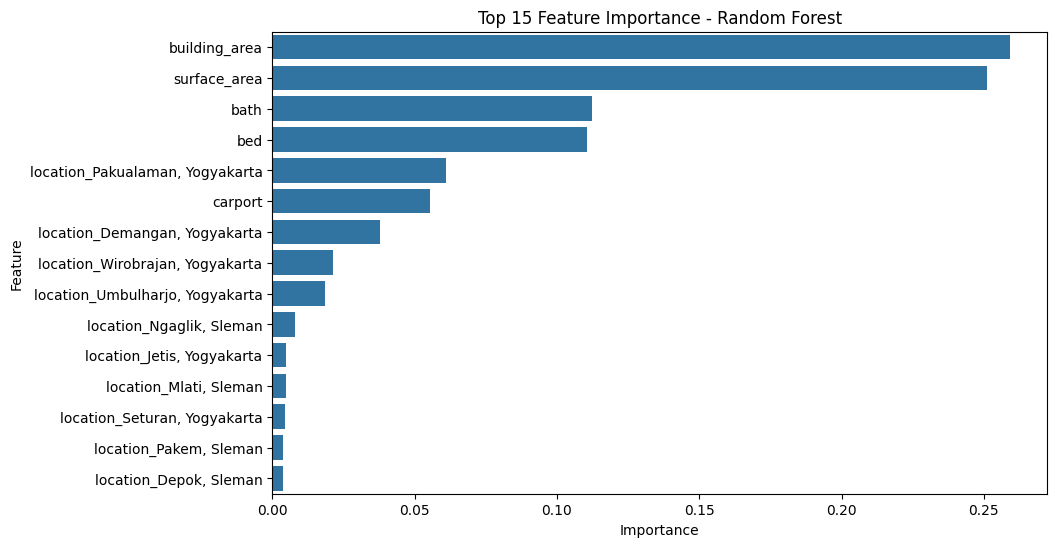

In [14]:
feature_names = (
    numerical_features +
    list(best_model.named_steps['preprocessor']
         .transformers_[1][1]
         .named_steps['onehot']
         .get_feature_names_out(categorical_features))
)

importances = best_model.named_steps['regressor'].feature_importances_
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(data=importance_df.head(15), x='Importance', y='Feature')
plt.title("Top 15 Feature Importance - Random Forest")
plt.show()

In [15]:
new_data = {
    'location': ['Depok, Sleman'],
    'bed': [2],
    'bath': [1],
    'carport': [0],
    'surface_area': [40],
    'building_area': [36]
}

new_df = pd.DataFrame(new_data)

predicted_price = best_model.predict(new_df)
print(f"\nPredicted Price: {predicted_price[0]:,.0f} IDR")


Predicted Price: 371,230,000 IDR


# Simpan Model ke Folder Backend/models

In [ ]:
import os
import joblib

save_dir = os.path.join("..", "house-price-prediction-website", "backend", "models")

os.makedirs(save_dir, exist_ok=True)

save_path = os.path.join(save_dir, "yogyakarta_model.pkl")

joblib.dump(best_model, save_path)

print(f"\n✅ Model berhasil disimpan di: {os.path.abspath(save_path)}")



✅ Model berhasil disimpan di: d:\Project\Python\Prediksi Harga Rumah\house-price-prediction-website\backend\models\yogyakarta_model.pkl
